## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import m5.config as cfg
from m5.utils import get_columns
from m5.evaluate import calculate_rmsse

import lightgbm as lgb
import gc

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)

## Parameters

In [4]:
level = 11

## Train

In [5]:
train = lgb.Dataset(str(cfg.DATA_DIR / f"processed/datasets/{level}/train.bin"))
val = lgb.Dataset(str(cfg.DATA_DIR / f"processed/datasets/{level}/val.bin"))

In [6]:
lgbm_params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 1000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 4,
    "early_stopping_round": 100,
}

In [7]:
model = lgb.train(lgbm_params, train, valid_sets=[val])

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Load from binary file /home/ariel/Playground/m5-forecasting/data/processed/datasets/11/train.bin
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7562
[LightGBM] [Info] Number of data points in the train set: 13624783, number of used features: 27
[LightGBM] [Info] Start training from score 1.527395
[1]	valid_0's tweedie: 8.38576
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 8.20399
[3]	valid_0's tweedie: 8.04904
[4]	valid_0's tweedie: 7.91582
[5]	valid_0's tweedie: 7.80359
[6]	valid_0's tweedie: 7.7082
[7]	valid_0's tweedie: 7.62748
[8]	valid_0's tweedie: 7.55897
[9]	valid_0's tweedie: 7.50147
[10]	valid_0's tweedie: 7.4536
[11]	valid_0's tweedie: 7.4126
[12]	valid_0's tweedie: 7.37798
[13]	valid_0's tweedie: 7.34879
[14]	va

In [8]:
model.save_model(str(cfg.ROOT_DIR / f"models/model_{level}.txt"))

## Predict

In [9]:
val = pd.read_parquet(cfg.DATA_DIR / f"processed/datasets/{level}/val.parquet")

In [10]:
train = pd.read_parquet(cfg.DATA_DIR / f"processed/datasets/{level}/train.parquet")

In [11]:
model = lgb.Booster(model_file=str(cfg.MODEL_DIR / f"model_{level}.txt"))

In [13]:
fcst_df = val[["item_id", "state_id", "d", "sales"]].copy()
fcst_df["fcst"] = model.predict(val.drop(columns=["sales"]))

In [14]:
fcst_df

,item_id,state_id,d,sales,fcst
13999810,0,0,1886,4,3.086317
14008957,0,0,1887,1,2.721245
14018104,0,0,1888,2,3.237421
14027251,0,0,1889,0,2.752825
14036398,0,0,1890,4,3.002682
...,...,...,...,...,...
14219337,3048,2,1909,0,0.262613
14228484,3048,2,1910,1,0.231287
14237631,3048,2,1911,0,0.289190
14246778,3048,2,1912,0,0.397018


(1800.0, 1920.0)

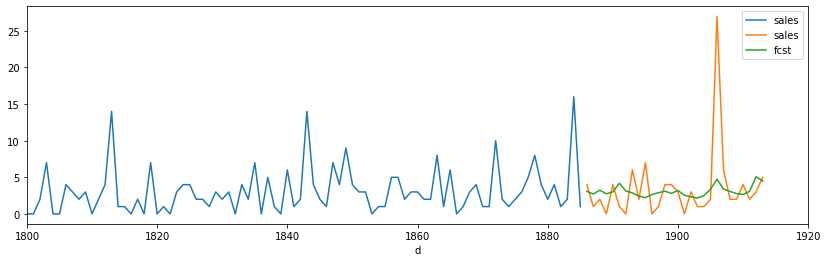

In [28]:
ID = (0, 0)
f, ax = plt.subplots()
train.loc[(train.item_id == ID[0]) & (train.state_id == ID[1]), ["sales", "d"]].set_index("d").plot(ax=ax)
fcst_df.loc[(fcst_df.item_id == ID[0]) & (fcst_df.state_id == ID[1]), ["sales", "fcst", "d"]].set_index("d").plot(ax=ax)
plt.xlim(left=1800, right=1920)

## Evaluate

In [29]:
data = pd.read_parquet(cfg.DATA_DIR / f"processed/levels/level-{level}.parquet")

In [30]:
data = data.loc[data.d < 1886, ["item_id", "state_id", "d", "sales", "dollar_sales"]]

In [31]:
data

,item_id,state_id,d,sales,dollar_sales
0,0,0,1,6,12.000000
1,1,0,1,3,23.639999
2,1,2,1,1,8.280000
3,2,0,1,9,25.920002
4,2,1,1,1,2.880000
...,...,...,...,...,...
13999805,3047,1,1885,0,0.000000
13999806,3047,2,1885,0,0.000000
13999807,3048,0,1885,2,11.880000
13999808,3048,1,1885,1,5.940000


In [32]:
total_dollar_sales = data["dollar_sales"].sum()
weights = data.groupby(["item_id", "state_id"])["dollar_sales"].agg(lambda x: x.sum() / total_dollar_sales).reset_index()
weights = weights.rename(columns={"dollar_sales": "weights"})

In [33]:
mse_naive_insample = data.groupby(["item_id", "state_id"])["sales"].agg(lambda x: (x.diff()**2).mean()).reset_index()
mse_naive_insample = mse_naive_insample.rename(columns={"sales": "mse_naive_insample"})

In [34]:
mse_fcst = fcst_df.groupby(["item_id", "state_id"]).apply(lambda df: ((df["sales"] - df["fcst"])**2).mean()).reset_index()
mse_fcst = mse_fcst.rename(columns={0: "mse_fcst"})

In [36]:
score_df = pd.merge(mse_fcst, mse_naive_insample, on=["item_id", "state_id"])

In [37]:
score_df["msse"] = score_df["mse_fcst"] / score_df["mse_naive_insample"]

In [38]:
score_df["rmsse"] = np.sqrt(score_df["msse"])

In [39]:
score_df = score_df.merge(weights, on=["item_id", "state_id"])

In [40]:
score_df

,item_id,state_id,mse_fcst,mse_naive_insample,msse,rmsse,weights
0,0,0,21.548042,20.966561,1.027734,1.013772,0.000077
1,0,1,1.271571,7.702602,0.165083,0.406304,0.000035
2,0,2,5.387213,3.917153,1.375288,1.172727,0.000029
3,1,0,2.624454,4.211253,0.623200,0.789430,0.000158
4,1,1,0.866177,1.862912,0.464959,0.681879,0.000062
...,...,...,...,...,...,...,...
9142,3047,1,0.115751,1.008557,0.114769,0.338775,0.000003
9143,3047,2,0.211526,0.767614,0.275563,0.524941,0.000003
9144,3048,0,0.993552,1.352098,0.734823,0.857218,0.000036
9145,3048,1,0.419029,1.102442,0.380092,0.616516,0.000030


In [44]:
score_df["weights"].sum()

0.99999887

In [49]:
wrmsse = (score_df["rmsse"] * score_df["weights"]).sum()
wrmsse

0.8038594626228545

## Playground